In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import ClusterCentroids

### Import CSV and Perform Data Cleaning

In [4]:
columns = ["status", "actual_duration", "arm_group_type", "intervention_type",
          "interventional_type_model", "phase", "fda_regulated_drug", "fda_regulated_device", "enrollment_count"]

In [5]:
# Load the interventional_study_o|nly
df = pd.read_csv('../Tables/updated_ivs_studies.csv')
df

,ID,title,actual_duration,status,study_type,arm_group_type,intervention_type,interventional_type_model,phase,fda_regulated_drug,fda_regulated_device,enrollment_count
0,IRST174.22,What is the Best Interval to Screen Women 45-4...,5.991781,Recruiting,Interventional,No Intervention,Diagnostic Test,Parallel Assignment,Not Applicable,No,No,60000
1,GCO 17-2188,Increasing African Immigrant Womens Participat...,3.320548,Recruiting,Interventional,Other,Behavioral,Single Group Assignment,Not Applicable,No,No,168
2,233756,The HIFUB Study (HIFU in Breast Cancer),0.504110,Not yet recruiting,Interventional,Experimental,Device,Single Group Assignment,Not Applicable,No,No,15
3,D16196,A Pilot Multi-Institutional Study to Evaluate ...,2.868493,Completed,Interventional,Experimental,Device,Single Group Assignment,Not Applicable,No,Yes,18
4,RO1912-30902,RCT Comparing 2 Radiotherapy HypoFractionation...,2.087671,Unknown status,Interventional,Other,Radiation,Parallel Assignment,Not Applicable,No,No,166
...,...,...,...,...,...,...,...,...,...,...,...,...
3931,20201491,Culturally Tailored Nurse Coaching Study for C...,1.684932,Recruiting,Interventional,Experimental,Behavioral,Parallel Assignment,Not Applicable,No,No,98
3932,32900654326,"TPVB, PECSB, ESPB for Postmastectmy Pain",2.336986,Completed,Interventional,Placebo Comparator,Procedure,Parallel Assignment,Not Applicable,No,No,80
3933,ReDA 13176,A Randomized Phase III Trial of Stereotactic A...,6.005479,Not yet recruiting,Interventional,Active Comparator,Radiation,Parallel Assignment,Phase 3,No,No,180
3934,64121317.4.1001.5330,Nivolumab in Prostate Cancer With DNA Repair D...,3.750685,"Active, not recruiting",Interventional,Experimental,Drug,Single Group Assignment,Phase 2,Yes,No,38


In [6]:
# Drop null rows
df = df.dropna()

In [7]:
# keep only the first values for 'arm group type' and 'intervention type'
df['arm_group_type'] = df['arm_group_type'].str.split(',').str[0]
df['intervention_type'] = df['intervention_type'].str.split(',').str[0]

In [8]:
df.head()

,ID,title,actual_duration,status,study_type,arm_group_type,intervention_type,interventional_type_model,phase,fda_regulated_drug,fda_regulated_device,enrollment_count
0,IRST174.22,What is the Best Interval to Screen Women 45-4...,5.991781,Recruiting,Interventional,No Intervention,Diagnostic Test,Parallel Assignment,Not Applicable,No,No,60000
1,GCO 17-2188,Increasing African Immigrant Womens Participat...,3.320548,Recruiting,Interventional,Other,Behavioral,Single Group Assignment,Not Applicable,No,No,168
2,233756,The HIFUB Study (HIFU in Breast Cancer),0.504110,Not yet recruiting,Interventional,Experimental,Device,Single Group Assignment,Not Applicable,No,No,15
3,D16196,A Pilot Multi-Institutional Study to Evaluate ...,2.868493,Completed,Interventional,Experimental,Device,Single Group Assignment,Not Applicable,No,Yes,18
4,RO1912-30902,RCT Comparing 2 Radiotherapy HypoFractionation...,2.087671,Unknown status,Interventional,Other,Radiation,Parallel Assignment,Not Applicable,No,No,166


In [9]:
# Drop rows with 'unknown status'
df = df.loc[df['status'] != 'Unknown status']

# categorize the status
replace_value = {
    'Completed':'high_chance',
    'Active, not recruiting': 'low_chance',
    'Enrolling by invitation': 'high_chance',
    'Not yet recruiting': 'low_chance',
    'Recruiting': 'high_chance',
    'Suspended': 'low_chance',
    'Terminated': 'low_chance',
    'Withdrawn': 'low_chance'
} 

df = df.replace({"status": replace_value})
df.head()

,ID,title,actual_duration,status,study_type,arm_group_type,intervention_type,interventional_type_model,phase,fda_regulated_drug,fda_regulated_device,enrollment_count
0,IRST174.22,What is the Best Interval to Screen Women 45-4...,5.991781,high_chance,Interventional,No Intervention,Diagnostic Test,Parallel Assignment,Not Applicable,No,No,60000
1,GCO 17-2188,Increasing African Immigrant Womens Participat...,3.320548,high_chance,Interventional,Other,Behavioral,Single Group Assignment,Not Applicable,No,No,168
2,233756,The HIFUB Study (HIFU in Breast Cancer),0.504110,low_chance,Interventional,Experimental,Device,Single Group Assignment,Not Applicable,No,No,15
3,D16196,A Pilot Multi-Institutional Study to Evaluate ...,2.868493,high_chance,Interventional,Experimental,Device,Single Group Assignment,Not Applicable,No,Yes,18
5,UMCC 2021.087,Avoiding Low-value Treatments in Older Women W...,0.969863,high_chance,Interventional,Experimental,Behavioral,Single Group Assignment,Not Applicable,No,No,40


In [10]:
ml_df = df[columns]
ml_df

,status,actual_duration,arm_group_type,intervention_type,interventional_type_model,phase,fda_regulated_drug,fda_regulated_device,enrollment_count
0,high_chance,5.991781,No Intervention,Diagnostic Test,Parallel Assignment,Not Applicable,No,No,60000
1,high_chance,3.320548,Other,Behavioral,Single Group Assignment,Not Applicable,No,No,168
2,low_chance,0.504110,Experimental,Device,Single Group Assignment,Not Applicable,No,No,15
3,high_chance,2.868493,Experimental,Device,Single Group Assignment,Not Applicable,No,Yes,18
5,high_chance,0.969863,Experimental,Behavioral,Single Group Assignment,Not Applicable,No,No,40
...,...,...,...,...,...,...,...,...,...
3931,high_chance,1.684932,Experimental,Behavioral,Parallel Assignment,Not Applicable,No,No,98
3932,high_chance,2.336986,Placebo Comparator,Procedure,Parallel Assignment,Not Applicable,No,No,80
3933,low_chance,6.005479,Active Comparator,Radiation,Parallel Assignment,Phase 3,No,No,180
3934,low_chance,3.750685,Experimental,Drug,Single Group Assignment,Phase 2,Yes,No,38


### Split the Data into Training and Testing

In [11]:
# Encode all columns into numbers to run through machine learning
ml_df['status'] = LabelEncoder().fit_transform(ml_df['status'])
y = ml_df.status
y


0       0
1       0
2       1
3       0
5       0
       ..
3931    0
3932    0
3933    1
3934    1
3935    0
Name: status, Length: 3599, dtype: int32

In [12]:
# prepare columns for machine learning through get_dummies
X = pd.get_dummies(ml_df,columns=['arm_group_type', 'intervention_type', 'interventional_type_model', 'phase', 'fda_regulated_drug', 'fda_regulated_device'])
X = X.drop('status', axis=1)
X.head()

,actual_duration,enrollment_count,arm_group_type_Active Comparator,arm_group_type_Experimental,arm_group_type_No Intervention,arm_group_type_Other,arm_group_type_Placebo Comparator,arm_group_type_Sham Comparator,intervention_type_Behavioral,intervention_type_Biological,...,phase_Phase 1,"phase_Phase 1, Phase 2",phase_Phase 2,"phase_Phase 2, Phase 3",phase_Phase 3,phase_Phase 4,fda_regulated_drug_No,fda_regulated_drug_Yes,fda_regulated_device_No,fda_regulated_device_Yes
0,5.991781,60000,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,3.320548,168,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
2,0.504110,15,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,2.868493,18,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,0.969863,40,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [13]:
# Check count, mean, max for features
X.describe()

,actual_duration,enrollment_count,arm_group_type_Active Comparator,arm_group_type_Experimental,arm_group_type_No Intervention,arm_group_type_Other,arm_group_type_Placebo Comparator,arm_group_type_Sham Comparator,intervention_type_Behavioral,intervention_type_Biological,...,phase_Phase 1,"phase_Phase 1, Phase 2",phase_Phase 2,"phase_Phase 2, Phase 3",phase_Phase 3,phase_Phase 4,fda_regulated_drug_No,fda_regulated_drug_Yes,fda_regulated_device_No,fda_regulated_device_Yes
count,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,...,3599.000000,3599.000000,3599.000000,3599.00000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000
mean,3.488654,496.203668,0.108363,0.810503,0.023618,0.045846,0.010558,0.001111,0.107252,0.049458,...,0.131148,0.079744,0.221728,0.01167,0.080300,0.024451,0.704084,0.295916,0.943040,0.056960
std,2.545801,4365.023155,0.310882,0.391957,0.151876,0.209180,0.102225,0.033324,0.309476,0.216853,...,0.337609,0.270935,0.415467,0.10741,0.271795,0.154467,0.456517,0.456517,0.231799,0.231799
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.732877,30.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3.002740,72.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,4.627397,194.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,20.079452,100000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# Check the balance of our target values
y.value_counts()

0    2428
1    1171
Name: status, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

# Create StandardScaler instance
scaler = StandardScaler()

# Fit Standard Scaler with training data
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Random Forest Classifier

In [16]:
# Create random forest classifier
rf_model = RandomForestClassifier(n_estimators=256, random_state=1)

# Fit the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [17]:
# Create prediction
y_pred = rf_model.predict(X_test)

In [18]:
# Define printing results for machine learning
def print_result(model):
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['Actual High Chance', 'Actual Low chance'], columns = ['Predicted High Chance', 'Predicted Low Chance'])

    # Calculate accuracy score
    acc_score = accuracy_score(y_test, y_pred)
    bal_acc_score = balanced_accuracy_score(y_test, y_pred)

    # Print results
    print(model + " Results\n")
    print("Confusion Matrix")
    display(cm_df)
    print(f'Accuracy Score: {acc_score}')
    print(f'Balanced Accuracy Score: {bal_acc_score}')
    print("---------------------------")
    print("Classfication Report")
    print(classification_report_imbalanced(y_test, y_pred))


In [19]:
print_result("Random Forest Classifier")

Random Forest Classifier Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,538,69
Actual Low chance,280,13


Accuracy Score: 0.6122222222222222
Balanced Accuracy Score: 0.4653473975406379
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.66      0.89      0.04      0.76      0.20      0.04       607
          1       0.16      0.04      0.89      0.07      0.20      0.04       293

avg / total       0.50      0.61      0.32      0.53      0.20      0.04       900



In [20]:
# Calculate feature importance
rf_importances = rf_model.feature_importances_

# sort features by importance
sorted(zip(rf_importances, X.columns), reverse=True)

[(0.4089124881228564, 'enrollment_count'),
 (0.3689242084088738, 'actual_duration'),
 (0.013484766134676723, 'intervention_type_Drug'),
 (0.013131306210368803, 'interventional_type_model_Parallel Assignment'),
 (0.012523050805521165, 'interventional_type_model_Single Group Assignment'),
 (0.01191142296234389, 'phase_Phase 2'),
 (0.011283510333878132, 'arm_group_type_Experimental'),
 (0.008911472911788646, 'arm_group_type_Active Comparator'),
 (0.008750074842437767, 'fda_regulated_drug_Yes'),
 (0.008743363860105116, 'fda_regulated_drug_No'),
 (0.008196445038581867, 'phase_Phase 1'),
 (0.00808245248958745, 'interventional_type_model_Sequential Assignment'),
 (0.008039862923866577, 'phase_Not Applicable'),
 (0.007595485031098664, 'intervention_type_Other'),
 (0.007218170335641319, 'intervention_type_Procedure'),
 (0.006675580493126814, 'phase_Phase 1, Phase 2'),
 (0.00658206896855104, 'intervention_type_Device'),
 (0.0063701260343225884, 'intervention_type_Biological'),
 (0.00611231384280

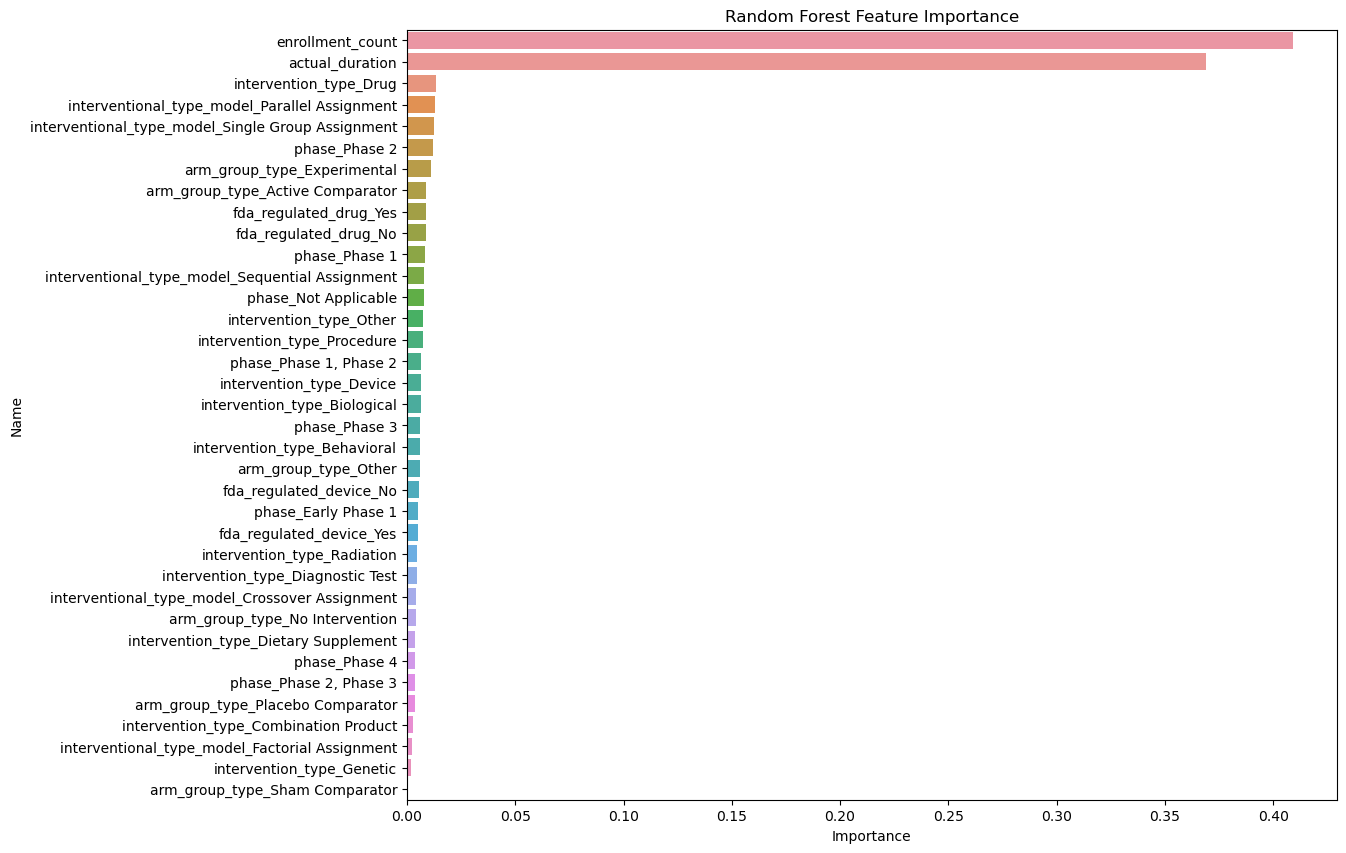

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# define function to plot feature importance
def plot_importance (importance, names, model_type):

    df = pd.DataFrame({'Names':names, 'Importance':importance})
    df.sort_values(by=['Importance'], ascending=False, inplace=True)

    plt.figure(figsize=(12,10))
    sns.barplot(x=df['Importance'], y=df['Names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Name')

    plt.show()

plot_importance(rf_importances, X.columns, 'Random Forest')

### Balanced Random Forest Classifier

In [22]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Instantiate model
brf_classifier = BalancedRandomForestClassifier(n_estimators=256, random_state=1)

# Fit model
brf_classifier.fit(X_train_scaled, y_train)

# Calculated the balanced accuracy score
y_pred = brf_classifier.predict(X_test)

In [23]:
print_result("Balanced Random Forest Classifier")

Balanced Random Forest Classifier Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,504,103
Actual Low chance,255,38


Accuracy Score: 0.6022222222222222
Balanced Accuracy Score: 0.4800029237957616
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.66      0.83      0.13      0.74      0.33      0.12       607
          1       0.27      0.13      0.83      0.18      0.33      0.10       293

avg / total       0.54      0.60      0.36      0.55      0.33      0.11       900



In [24]:
# Calculate feature importance
brf_importances = brf_classifier.feature_importances_

# List the features sorted in descending order by feature importance
features_rank = sorted(zip(brf_importances, X.columns), reverse=True)
for feature in features_rank:
    print(f"{feature[1]}: ({feature[0]})")

enrollment_count: (0.3780823658304868)
actual_duration: (0.3548002886917413)
interventional_type_model_Parallel Assignment: (0.016207192155333828)
intervention_type_Drug: (0.01547660925406316)
interventional_type_model_Single Group Assignment: (0.015228447889115647)
phase_Phase 2: (0.014040495829420194)
arm_group_type_Experimental: (0.013753898908487772)
intervention_type_Other: (0.010578978935089803)
phase_Not Applicable: (0.010484803050840315)
arm_group_type_Active Comparator: (0.010235660461112947)
phase_Phase 1: (0.010014051117189091)
interventional_type_model_Sequential Assignment: (0.009583163436414606)
fda_regulated_drug_No: (0.009575722582351722)
intervention_type_Procedure: (0.009522248180803841)
fda_regulated_drug_Yes: (0.009302339025627474)
phase_Phase 1, Phase 2: (0.008580611421647847)
intervention_type_Device: (0.008460093698870411)
intervention_type_Behavioral: (0.008257573815848079)
intervention_type_Biological: (0.007798707639520879)
arm_group_type_Other: (0.00725112148

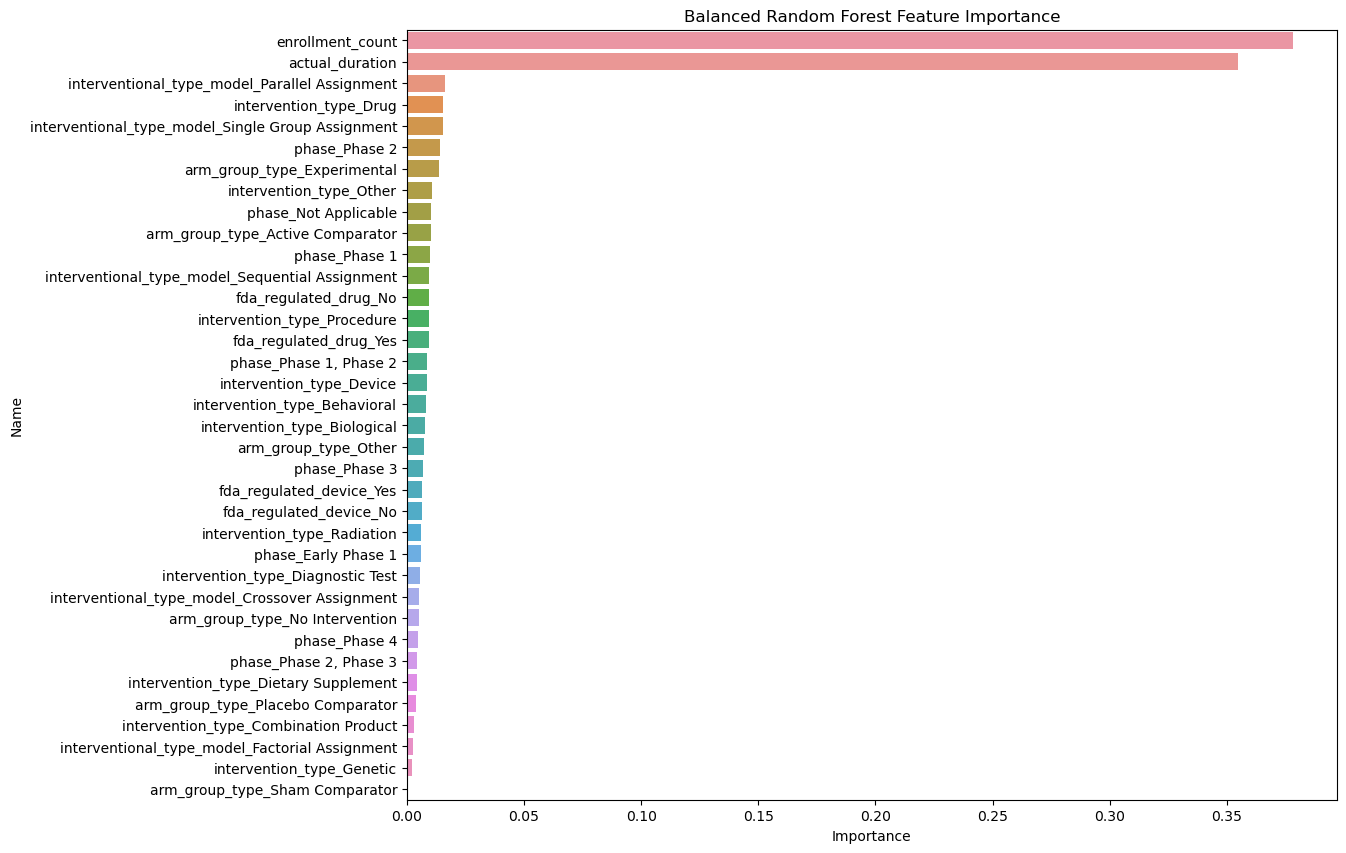

In [25]:
plot_importance(brf_importances, X.columns, 'Balanced Random Forest')

### Logistic Regression

In [26]:
# Declare model
lr_model = LogisticRegression(solver='lbfgs', random_state=42)

# fit the model
lr_model = lr_model.fit(X_train_scaled, y_train)

# create prediction
y_pred = lr_model.predict(X_test_scaled)

In [27]:
print_result("Logistic Regression")

Logistic Regression Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,593,14
Actual Low chance,282,11


Accuracy Score: 0.6711111111111111
Balanced Accuracy Score: 0.5072392058520896
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.68      0.98      0.04      0.80      0.19      0.04       607
          1       0.44      0.04      0.98      0.07      0.19      0.03       293

avg / total       0.60      0.67      0.34      0.56      0.19      0.04       900



### Optimize model, Use resampling techniques to determine the best performing algorithm

#### Oversampling

- Random Over Sampler

In [28]:
# Define function to re-run machine learning through resampling models

def resample_ml(model):
    classifier = LogisticRegression(solver='lbfgs', random_state=1)
    X_resampled, y_resampled = model.fit_resample(X_train_scaled, y_train)
    classifier.fit(X_resampled, y_resampled)
    y_pred = classifier.predict(X_test)
    

In [29]:
# Resample with RandomOverSampler
resample_ml(RandomOverSampler(random_state=1))

In [30]:
print_result("Random Over Sampling")

Random Over Sampling Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,593,14
Actual Low chance,282,11


Accuracy Score: 0.6711111111111111
Balanced Accuracy Score: 0.5072392058520896
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.68      0.98      0.04      0.80      0.19      0.04       607
          1       0.44      0.04      0.98      0.07      0.19      0.03       293

avg / total       0.60      0.67      0.34      0.56      0.19      0.04       900



- SMOTE

In [31]:
# resample through SMOTE model
resample_ml(SMOTE(random_state=1))

In [32]:
print_result("SMOTE")

SMOTE Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,593,14
Actual Low chance,282,11


Accuracy Score: 0.6711111111111111
Balanced Accuracy Score: 0.5072392058520896
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.68      0.98      0.04      0.80      0.19      0.04       607
          1       0.44      0.04      0.98      0.07      0.19      0.03       293

avg / total       0.60      0.67      0.34      0.56      0.19      0.04       900



#### Undersampling

In [33]:
# Resample the data using the ClusterCentroids resampler
resample_ml(ClusterCentroids(random_state=1))

In [34]:
print_result("Cluster Centroids")

Cluster Centroids Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,593,14
Actual Low chance,282,11


Accuracy Score: 0.6711111111111111
Balanced Accuracy Score: 0.5072392058520896
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.68      0.98      0.04      0.80      0.19      0.04       607
          1       0.44      0.04      0.98      0.07      0.19      0.03       293

avg / total       0.60      0.67      0.34      0.56      0.19      0.04       900



#### Combination (Over and Under) Sampling

In [35]:
# Resample using SMOTEENN
resample_ml(SMOTEENN(random_state=1))

In [36]:
print_result("SMOTEENN")

SMOTEENN Results

Confusion Matrix


,Predicted High Chance,Predicted Low Chance
Actual High Chance,593,14
Actual Low chance,282,11


Accuracy Score: 0.6711111111111111
Balanced Accuracy Score: 0.5072392058520896
---------------------------
Classfication Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.68      0.98      0.04      0.80      0.19      0.04       607
          1       0.44      0.04      0.98      0.07      0.19      0.03       293

avg / total       0.60      0.67      0.34      0.56      0.19      0.04       900

